# What this script does

# I. SETTINGS

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# II. DATA

### Import

In [2]:
# Deficiencies (from CMS database)
df_sod_orig = pd.read_csv('../C_output_data/sod_wa.csv', 
                             dtype='object', parse_dates=['inspection_dt'])

# Penalties (scraped from the enforcement letter PDFs)
df_cmp_orig = pd.read_csv('../C_output_data/scraped_data_v2.csv', 
                              parse_dates=['letter_dt', 'survey_dt'])

# WAC code details
df_wac = pd.read_csv('../C_output_data/wac_codes_df_t338c97.csv')

# Hours per resident per day
df_hprd_orig = pd.read_excel('../A_source_data/DSHS/3.4 HPRD - PBJ Data - Starting Q3 2018 - CURRENT - with federal provider numbers.xlsx',
                              sheet_name='PBJ 3.4 HPRD', header=11, usecols='A:M',
                              dtype={'Vendor #':np.int32})

# COVID Outbreaks
df_ob_orig = pd.read_csv('../C_output_data/outbreaks.csv')

### Create working copies

In [3]:
df_sod = df_sod_orig.copy()
df_cmp = df_cmp_orig.copy()
df_ob = df_ob_orig.copy()

The **df_hprd_orig** dataframe needs a bit of extra work. We will process them later.

### Facilities mapping table

In [4]:
df_fac_map = df_sod[['facility_id','facility_name']]
df_fac_map = df_fac_map.drop_duplicates().set_index('facility_id')
df_fac_map

facility_name
facility_id                                             
505004        ISSAQUAH NURSING AND REHABILITATION CENTER
505009                            PARK RIDGE CARE CENTER
505010                                    GARDEN VILLAGE
505016       GRAYS HARBOR HEALTH & REHABILITATION CENTER
505017                            WASHINGTON CARE CENTER
...                                                  ...
505466                                       KENNEY, THE
50A273        WASHINGTON STATE WALLA WALLA VETERANS HOME
505381                    SAN JUAN REHAB AND CARE CENTER
505332          LIFE CARE CENTER OF THE SAN JUAN ISLANDS
505521                       KINDRED SEATTLE - NORTHGATE

[226 rows x 1 columns]

# III. The two aspects: Nurse staffing & HPRD

## III.1. Nurse staffing

### Deficiencies

From the [CMS federal tag list](https://www.cms.gov/Medicare/Provider-Enrollment-and-Certification/GuidanceforLawsAndRegulations/Downloads/List-of-Revised-FTags.pdf), we identified the federal tags that are related to staffing:

In [5]:
staff_tags = pd.DataFrame([['725', 'Sufficient Nursing Staff'],
                           ['726', 'Competent Nursing Staff']],
                          columns=['tag', 'tag_desc'])
staff_tags

tag                  tag_desc
0  725  Sufficient Nursing Staff
1  726   Competent Nursing Staff

In [6]:
# Reduce to only staff-related deficiency tags
df_sod_staff = df_sod[df_sod['tag'].isin(staff_tags['tag'])]

# Add the tag descriptions
df_sod_staff = df_sod_staff.join(staff_tags.set_index('tag'), on='tag', how='left')

df_sod_staff = df_sod_staff.reset_index(drop=True)

In [7]:
print(df_sod_staff.shape)
print(df_sod_staff['inspection_dt'].min())
print(df_sod_staff['inspection_dt'].max())
print('\n')
print(df_sod_staff['tag_desc'].value_counts(dropna=False))

(229, 13)
2017-12-12 00:00:00
2020-02-26 00:00:00


Sufficient Nursing Staff    154
Competent Nursing Staff      75
Name: tag_desc, dtype: int64


### Penalties

Reduce **df_cmp** to only penalties related to staffing deficiencies ([WAC code 388-97-1080](https://apps.leg.wa.gov/wac/default.aspx?cite=388-97-1080))

In [8]:
df_cmp_staff = df_cmp[df_cmp['wac_short']=='388-97-1080']
df_cmp_staff = df_cmp_staff.reset_index(drop=True)

In [9]:
print(df_cmp_staff.shape)
print(df_cmp_staff['survey_dt'].min())
print(df_cmp_staff['survey_dt'].max())

(18, 18)
2017-02-07 00:00:00
2020-03-16 00:00:00


The time frame for the penalties data is larger than the one or the deficiencies data. We need to syncronize them.

In [10]:
start_dt = df_sod_staff['inspection_dt'].min()
end_dt = df_sod_staff['inspection_dt'].max()

df_cmp_staff = df_cmp_staff[df_cmp_staff['survey_dt']>=start_dt]
df_cmp_staff = df_cmp_staff[df_cmp_staff['survey_dt']<=end_dt]

In [11]:
print(df_cmp_staff.shape)
print(df_cmp_staff['survey_dt'].min())
print(df_cmp_staff['survey_dt'].max())

(11, 18)
2018-04-12 00:00:00
2020-01-27 00:00:00


## III.2. HPRD

### Deficiencies

In [12]:
df_hprd = df_hprd_orig.copy()

# # Clean column names
df_hprd.columns = df_hprd.columns.str.lower().str.replace(' ','_').str.replace('#','num').str.replace('_total', '')
df_hprd.columns = df_hprd.columns.str.replace('_no_don_for_providers_>=61_beds','')

# Create a proper quarter date variable
df_hprd['year_q'] = pd.to_datetime(df_hprd['year'].astype(str) + 'Q' + df_hprd['quarter'].astype(str)) 
df_hprd['year_q'] = df_hprd['year_q'] + pd.offsets.QuarterEnd(0)

# Data for 2020 is still incomplete, so we leave it out
# df_hprd = df_hprd[df_hprd['year_q']>='2018-07-01']
df_hprd = df_hprd[df_hprd['year_q']<='2019-12-31']

# Drop unnecesary columns
df_hprd = df_hprd.drop(['year','quarter','ln','aides','census','behav','num_of_beds','don_hprd'], axis=1)

# Save the index to use later, for a consistency test
i = df_hprd.index

# Divide the datset into two: Before/after 2019-Q3 (The HPRD column changes after that date)
df_hprd1 = df_hprd[df_hprd['year_q'] < '2019-09-30']
df_hprd2 = df_hprd[df_hprd['year_q'] >= '2019-09-30']

# In each dataset, leave only the appropriate HPRD column and rename it
df_hprd1 = df_hprd1.drop(['hprd_q_(hb1564)'], axis=1)
df_hprd1 = df_hprd1.rename(columns={'hprd_q':'hprd'})

df_hprd2 = df_hprd2.drop(['hprd_q'], axis=1)
df_hprd2 = df_hprd2.rename(columns={'hprd_q_(hb1564)':'hprd'})

# Join back
del(df_hprd)
df_hprd = pd.concat([df_hprd1,df_hprd2])

assert (df_hprd.index == i).all()

# 'hprd' is a string series; convert to float
df_hprd['hprd'] = df_hprd['hprd'].replace('x', np.nan)
df_hprd['hprd'] = df_hprd['hprd'].astype(np.float64)

# Build a variable that identifies if a facility went below the minimum number of hours of service
df_hprd['below_state'] =  df_hprd['hprd'] < 3.4
df_hprd['below_fed'] =  df_hprd['hprd'] < 4.1

### Penalties

Reduce **df_cmp** to only penalties related to deficiencies in the number of hours per patiet per day ([WAC code 388-97-1090](https://apps.leg.wa.gov/wac/default.aspx?cite=388-97-1090))

In [13]:
# Reduce df_cmp to only WACs related to direct care hours
df_cmp_hprd = df_cmp[df_cmp['wac_short']=='388-97-1090']

# Reduce to dates that are inside 2018Q3-2019Q4
df_cmp_hprd = df_cmp_hprd[df_cmp_hprd['survey_dt']>='2018-07-01']
df_cmp_hprd = df_cmp_hprd[df_cmp_hprd['survey_dt']<='2019-12-31']

df_cmp_hprd = df_cmp_hprd.reset_index(drop=True)

In [14]:
print(df_cmp_hprd.shape)

print(df_cmp_hprd['survey_dt'].min())
print(df_cmp_hprd['survey_dt'].max())
print('\n')
print(df_cmp_hprd['letter_dt'].min())
print(df_cmp_hprd['letter_dt'].max())

(13, 18)
2019-07-09 00:00:00
2019-11-26 00:00:00


2019-07-17 00:00:00
2020-01-16 00:00:00


# IV. ANALYSIS

## IV.1. HPRD

### Deficiencies

We have data that shows how many hours per client per day each facility provided each quarter.

First, let's find out the number of facilities that provided less than the required minimum number of hours each quarter.

There were 20 individual facilities that fell below that minimum in at least one quarter.



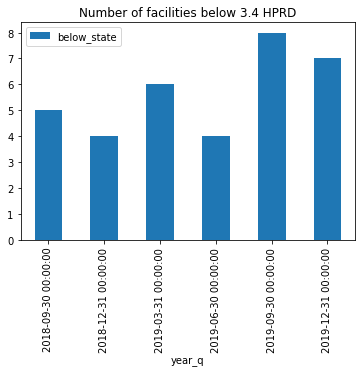

In [15]:
temp = df_hprd[['year_q', 'below_state']]
temp = temp.groupby('year_q').sum()

print('There were', df_hprd[df_hprd['below_state']]['federal_provider_number'].nunique(),
     'individual facilities that fell below that minimum in at least one quarter.\n')

temp.plot(kind='bar', title='Number of facilities below 3.4 HPRD')

There were 153 individual facilities that fell below that minimum in at least one quarter.



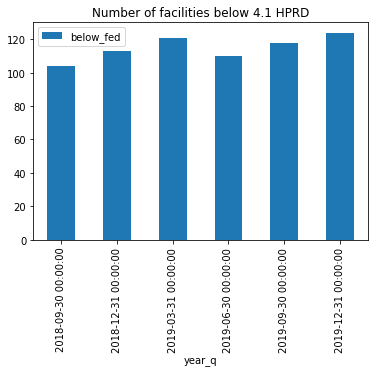

In [16]:
temp = df_hprd[['year_q', 'below_fed']]
temp = temp.groupby('year_q').sum()

print('There were', df_hprd[df_hprd['below_fed']]['federal_provider_number'].nunique(),
     'individual facilities that fell below that minimum in at least one quarter.\n')

temp.plot(kind='bar', title='Number of facilities below 4.1 HPRD')

### Penalties

Between 2019-07-17 00:00:00 and 2020-01-16 00:00:00 
the DSHS fined 8 facilities a total of $ 0.4 MM for deficiencies related to direct care hours



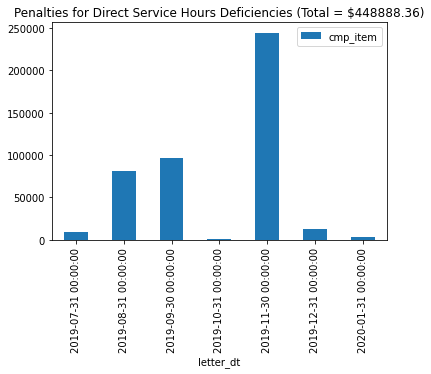

In [17]:
print('Between', df_cmp_hprd['letter_dt'].min(), 'and', df_cmp_hprd['letter_dt'].max(),
      '\nthe DSHS fined', df_cmp_hprd['manual_cms_number'].nunique(), 'facilities a total of $',
      round(df_cmp_hprd['cmp_item'].sum()/1e6,1),'MM',
     'for deficiencies related to direct care hours')
print('\r')

piv = df_cmp_hprd.pivot_table(index='letter_dt', values='cmp_item', aggfunc='sum', fill_value = 0).resample('M').sum()

piv.plot(kind='bar', 
         title='Penalties for Direct Service Hours Deficiencies (Total = $' + str(df_cmp_hprd['cmp_item'].sum()) + ')')

### Facilities

In [18]:
# Total number of deficiencies per facility federal number
temp = df_hprd[df_hprd['below_state']]
temp = pd.DataFrame(temp['federal_provider_number'].value_counts(dropna=False))
temp.columns = ['num_deficiencies']

# Total 1090 fines per facility federal number
temp2 = df_cmp_hprd[df_cmp_hprd['survey_dt'] >= '2018-01-01']
temp2 = temp2[['manual_cms_number','cmp_item']]
temp2 = temp2.groupby(['manual_cms_number']).sum()

# Join
df_summ_hprd = temp.join(temp2, how='outer')
df_summ_hprd = df_summ_hprd.join(df_fac_map, how='left')
df_summ_hprd = df_summ_hprd[['facility_name','num_deficiencies','cmp_item']]
df_summ_hprd = df_summ_hprd.sort_values(['num_deficiencies','cmp_item'], ascending=False)

del(temp, temp2)

# Consistency test
assert round(df_summ_hprd['cmp_item'].sum()) == round(df_cmp_hprd['cmp_item'].sum())

print(df_summ_hprd['cmp_item'].sum())

df_summ_hprd

448888.3599999999


facility_name  num_deficiencies  \
505240                         FOREST RIDGE HEALTH & REHAB                 5   
505185          CRESTWOOD HEALTH AND REHABILITATION CENTER                 4   
505151                                CASHMERE CARE CENTER                 3   
505232                        WOODLAND CONVALESCENT CENTER                 2   
505361                        AMERICANA HEALTH & REHAB CTR                 2   
505390                        MCKAY HEALTHCARE & REHAB CTR                 2   
505230                       FIR LANE HEALTH AND REHAB CTR                 2   
505503                   MONTESANO HEALTH & REHABILITATION                 2   
505306                   LIFE CARE CENTER OF PORT TOWNSEND                 1   
505378         PRESTIGE CARE & REHABILITATION - BURLINGTON                 1   
505085                           CRESCENT HEALTH CARE, INC                 1   
505114                          GARDENS ON UNIVERSITY, THE                 1   
505140                  HIGHLAND HEALTH AND REHABILITATION                 1   
505154            TACOMA NURSING AND REHABILITATION CENTER                 1   
505236                    ALDERCREST HEALTH & REHAB CENTER                 1   
505288                    PARK ROYAL HEALTH & REHAB CENTER                 1   
505291  RIVERVIEW LUTHERAN RETIREMENT COMMUNITY OF SPOKANE                 1   
505325             BAINBRIDGE ISLAND HEALTH & REHAB CENTER                 1   
505358                       RIVERSIDE NURSING & REHAB CTR                 1   
505519                BENSON HEIGHTS REHABILITATION CENTER                 1   

         cmp_item  
505240  238931.59  
505185   17707.46  
505151    2173.25  
505232   96909.62  
505361   13140.91  
505390   10206.88  
505230        NaN  
505503        NaN  
505306   69282.25  
505378     536.40  
505085        NaN  
505114        NaN  
505140        NaN  
505154        NaN  
505236        NaN  
505288        NaN  
505291        NaN  
505325        NaN  
505358        NaN  
505519        NaN

## IV.2. Staffing

### Deficiencies

In [19]:
temp = df_sod[(df_sod['inspection_dt'] >= df_sod_staff['inspection_dt'].min()) &
              (df_sod['inspection_dt'] <= df_sod_staff['inspection_dt'].max())]
print(temp['eventid'].nunique())
print(temp['facility_id'].nunique())

1474
217


Between 2017-12-12 00:00:00 and 2020-02-26 00:00:00 
there were 229 CMS staff-related deficiencies found across 118 facilities.

Sufficient Nursing Staff    154
Competent Nursing Staff      75
Name: tag_desc, dtype: int64


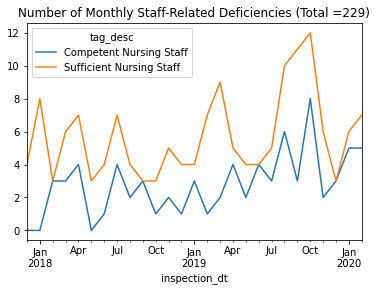

In [20]:
print('Between', df_sod_staff['inspection_dt'].min(), 
      'and', df_sod_staff['inspection_dt'].max(),
      '\nthere were', len(df_sod_staff), 'CMS staff-related deficiencies found across', 
      df_sod_staff['facility_id'].nunique(), 'facilities.\n')

print(df_sod_staff['tag_desc'].value_counts(dropna=False))

piv = df_sod_staff.pivot_table(index='inspection_dt', columns='tag_desc', values='facility_id', aggfunc='count', fill_value = 0).resample('M').sum()
piv.to_csv('/Users/mvilla/Downloads/deficiencies_timeline_1080.csv')
piv.plot(title='Number of Monthly Staff-Related Deficiencies (Total ='+str(len(df_sod_staff))+')')

### Penalties

Between 2018-04-12 00:00:00 and 2020-01-27 00:00:00 
the DSHS fined 9 facilities a total of 11500.0 for deficiencies related to nursing services, which include staffing.



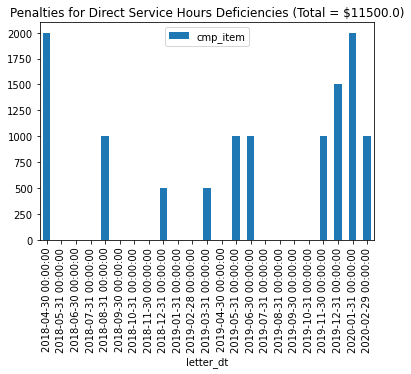

In [21]:
print('Between', df_cmp_staff['survey_dt'].min(), 'and', df_cmp_staff['survey_dt'].max(),
      '\nthe DSHS fined', df_cmp_staff['manual_cms_number'].nunique(), 'facilities a total of',
      df_cmp_staff['cmp_item'].sum(),
     'for deficiencies related to nursing services, which include staffing.')
print('\r')

piv = df_cmp_staff.pivot_table(index='letter_dt', values='cmp_item', aggfunc='sum', fill_value = 0).resample('M').sum()
piv.to_csv('/Users/mvilla/Downloads/penalties_timeline_1080.csv')
piv.plot(kind='bar', 
         title='Penalties for Direct Service Hours Deficiencies (Total = $' + str(df_cmp_staff['cmp_item'].sum()) + ')')



In [22]:
df_cmp_staff.groupby(['wac_long']).sum()

cmp_item  cmp_agg
wac_long                            
388-97-1080(1)       3000.0      0.0
388-97-1080(3)       5000.0      0.0
388-97-1080(3)(b)    1000.0      0.0
388-97-1080(3)(g)    1000.0      0.0
388-97-1080(8)       1500.0      0.0

In [23]:
temp = df_cmp_staff[df_cmp_staff['letter_dt'] >= '2018-01-01']
temp = temp[~temp['cmp_item'].isna()][['facility_name', 'letter_dt', 'cmp_item']]
temp.sort_values(['facility_name', 'letter_dt'])

facility_name  letter_dt  cmp_item
0    AVALON HEALTH & REHABILITATION CENTER - PASCO 2018-08-16    1000.0
2         AVAMERE TRANSITIONAL CARE OF PUGET SOUND 2019-03-08     500.0
1         AVAMERE TRANSITIONAL CARE OF PUGET SOUND 2019-05-03    1000.0
3   BREMERTON CONVALESCENT & REHABILITATION CENTER 2020-02-04    1000.0
6                    LIFE CARE CENTER OF KENNEWICK 2018-04-26    2000.0
8                    REGENCY CARE CENTER AT MONROE 2018-12-04     500.0
10        TACOMA NURSING AND REHABILITATION CENTER 2019-12-10    1500.0
9         TACOMA NURSING AND REHABILITATION CENTER 2020-01-29    1500.0
11                          VIEW RIDGE CARE CENTER 2020-01-29     500.0
12                  WASHINGTON VETERAN HOME-RETSIL 2019-06-24    1000.0
13                      WESLEY HOMES HEALTH CENTER 2019-11-06    1000.0

### Facilities

In [24]:
# Total number of deficiencies per facility federal number
temp = df_sod_staff[df_sod_staff['inspection_dt'] >= '2018-01-01']
print(temp['inspection_dt'].max())
temp = pd.DataFrame(temp['facility_id'].value_counts(dropna=False))
temp.columns = ['num_deficiencies']

# Total 1080 fines per facility federal number
temp2 = df_cmp_staff[df_cmp_staff['survey_dt'] >= '2018-01-01']
print(temp2['survey_dt'].max())
temp2 = temp2[['manual_cms_number','cmp_item']]
temp2 = temp2.groupby(['manual_cms_number']).sum()

# Join
df_summ_1080 = temp.join(temp2, how='outer')
df_summ_1080 = df_summ_1080.join(df_fac_map, how='left')
df_summ_1080 = df_summ_1080[['facility_name','num_deficiencies','cmp_item']]
df_summ_1080 = df_summ_1080.sort_values(['num_deficiencies'], ascending=False)

del(temp, temp2)

2020-02-26 00:00:00
2020-01-27 00:00:00


In [25]:
print(df_summ_1080['cmp_item'].sum())
df_summ_1080.head(20)

11500.0


facility_name  num_deficiencies  \
505386                           MARYSVILLE CARE CENTER               6.0   
505185       CRESTWOOD HEALTH AND REHABILITATION CENTER               6.0   
505507                    SHELTON HEALTH & REHAB CENTER               5.0   
505511             PARAMOUNT REHABILITATION AND NURSING               4.0   
505230                    FIR LANE HEALTH AND REHAB CTR               4.0   
505473           UNIVERSITY PLACE REHABILITATION CENTER               4.0   
505276                   FRONTIER REHAB & EXTENDED CARE               4.0   
505491                                   EVERETT CENTER               4.0   
505269               VANCOUVER SPECIALTY AND REHAB CARE               3.0   
505223  AVAMERE BELLINGHAM HEALTH CARE & REHAB SERVICES               3.0   
505236                 ALDERCREST HEALTH & REHAB CENTER               3.0   
505257                                  ALDERWOOD MANOR               3.0   
505260                        FORT VANCOUVER POST ACUTE               3.0   
505262              SHORELINE HEALTH AND REHABILITATION               3.0   
505496                AVALON CARE CENTER AT NORTHPOINTE               3.0   
505272                 LIFE CARE CENTER OF MOUNT VERNON               3.0   
505202             TALBOT CENTER FOR REHAB & HEALTHCARE               3.0   
505488                             RICHMOND BEACH REHAB               3.0   
505483         ALASKA GARDENS HEALTH AND REHABILITATION               3.0   
505339        REGENCY NORTH BEND REHAB & NURSING CENTER               3.0   

        cmp_item  
505386       NaN  
505185       NaN  
505507       NaN  
505511       NaN  
505230       NaN  
505473       NaN  
505276       NaN  
505491       NaN  
505269       NaN  
505223       NaN  
505236       NaN  
505257       NaN  
505260       NaN  
505262       NaN  
505496       NaN  
505272       NaN  
505202       NaN  
505488       NaN  
505483       NaN  
505339       NaN

Confirm if any of the facilities mentioned in the article were fined during the period 2018Q3-2019Q4

In [26]:
mentioned_homes = 'everet|genesis|forest bay|marysville'

In [27]:
df_summ_1080[df_summ_1080['facility_name'].str.lower().str.contains(mentioned_homes)]

facility_name  num_deficiencies  cmp_item
505386  MARYSVILLE CARE CENTER               6.0       NaN
505491          EVERETT CENTER               4.0       NaN
505214  THE OAKS AT FOREST BAY               2.0       NaN

In [28]:
df_cmp_staff['facility_name'].str.lower().str.contains(mentioned_homes).any()

False

In [29]:
df_cmp_hprd['facility_name'].str.lower().str.contains(mentioned_homes).any()

False

In [30]:
df_summ_1080[~df_summ_1080['cmp_item'].isna()]

facility_name  num_deficiencies  \
505126   AVALON HEALTH & REHABILITATION CENTER - PASCO               3.0   
505362                          VIEW RIDGE CARE CENTER               2.0   
505123  BREMERTON CONVALESCENT & REHABILITATION CENTER               2.0   
505154        TACOMA NURSING AND REHABILITATION CENTER               2.0   
505517                  WASHINGTON VETERAN HOME-RETSIL               1.0   
505080                   LIFE CARE CENTER OF KENNEWICK               1.0   
505350                   REGENCY CARE CENTER AT MONROE               1.0   
505475                      WESLEY HOMES HEALTH CENTER               NaN   
505529        AVAMERE TRANSITIONAL CARE OF PUGET SOUND               NaN   

        cmp_item  
505126    1000.0  
505362     500.0  
505123    1000.0  
505154    3000.0  
505517    1000.0  
505080    2000.0  
505350     500.0  
505475    1000.0  
505529    1500.0

# IV. Outbreaks

In [31]:
df_ob[df_ob['federal_num'].isna()]

federal_num       facility_name  beds  cases  deaths  case_rate  \
171         NaN       Sunrise Haven     8      0       0        0.0   
200         NaN  Franke Tobey Jones    43      0       0        0.0   

     death_rate  
171         0.0  
200         0.0

In [32]:
df_ob = df_ob.set_index(['federal_num'])
df_ob

facility_name  beds  cases  \
federal_num                                                                 
505098                Shuksan Rehabilitation And Health Care    52     74   
505263       Prestige Post-Acute And Rehab Center - Kittitas    74    102   
505463                      Sunrise View Convalescent Center    59     79   
505265                                          Emerald Care    82     99   
505010                                        Garden Village   101    119   
...                                                      ...   ...    ...   
505531                                           Heron'S Key    30      0   
50A263                     Lakeland Village Nursing Facility    93      0   
505306                     Life Care Center Of Port Townsend    94      0   
505525                    Manor Care Health Services - Lacey   120      0   
50A261                                  Yakima Valley School   160      0   

             deaths  case_rate  death_rate  
federal_num                                 
505098           15   1.423077    0.288462  
505263           15   1.378378    0.202703  
505463           15   1.338983    0.254237  
505265            5   1.207317    0.060976  
505010           16   1.178218    0.158416  
...             ...        ...         ...  
505531            0   0.000000    0.000000  
50A263            0   0.000000    0.000000  
505306            0   0.000000    0.000000  
505525            0   0.000000    0.000000  
50A261            0   0.000000    0.000000  

[209 rows x 6 columns]

In [33]:
staff_v_ob = df_summ_1080.join(df_ob, how='outer', lsuffix='_staff', rsuffix='_out')
staff_v_ob.to_csv('/Users/mvilla/Downloads/oubtreaks_vs_1080.csv')
staff_v_ob

facility_name_staff  num_deficiencies  cmp_item  \
505004                             NaN               NaN       NaN   
505009                             NaN               NaN       NaN   
505010                  GARDEN VILLAGE               1.0       NaN   
505016                             NaN               NaN       NaN   
505017  WASHINGTON CENTER FOR COMPREHE               1.0       NaN   
...                                ...               ...       ...   
50A260                             NaN               NaN       NaN   
50A261            YAKIMA VALLEY SCHOOL               1.0       NaN   
50A263                             NaN               NaN       NaN   
NaN                                NaN               NaN       NaN   
NaN                                NaN               NaN       NaN   

                                  facility_name_out   beds  cases  deaths  \
505004     Issaquah Nursing & Rehabilitation Center  140.0   96.0    19.0   
505009                       Park Ridge Care Center  115.0   92.0    20.0   
505010                               Garden Village  101.0  119.0    16.0   
505016  Grays Harbor Health & Rehabilitation Center  105.0    0.0     0.0   
505017                       Washington Care Center  165.0   74.0    14.0   
...                                             ...    ...    ...     ...   
50A260                        Fircrest School Pat N   92.0    0.0     0.0   
50A261                         Yakima Valley School  160.0    0.0     0.0   
50A263            Lakeland Village Nursing Facility   93.0    0.0     0.0   
NaN                                   Sunrise Haven    8.0    0.0     0.0   
NaN                              Franke Tobey Jones   43.0    0.0     0.0   

        case_rate  death_rate  
505004   0.685714    0.135714  
505009   0.800000    0.173913  
505010   1.178218    0.158416  
505016   0.000000    0.000000  
505017   0.448485    0.084848  
...           ...         ...  
50A260   0.000000    0.000000  
50A261   0.000000    0.000000  
50A263   0.000000    0.000000  
NaN      0.000000    0.000000  
NaN      0.000000    0.000000  

[212 rows x 9 columns]

In [34]:
hprd_v_ob = df_summ_hprd.join(df_ob, how='outer', lsuffix='_staff', rsuffix='_out')
hprd_v_ob.to_csv('/Users/mvilla/Downloads/oubtreaks_vs_1090.csv')
hprd_v_ob

facility_name_staff  num_deficiencies  cmp_item  \
505004                 NaN               NaN       NaN   
505009                 NaN               NaN       NaN   
505010                 NaN               NaN       NaN   
505016                 NaN               NaN       NaN   
505017                 NaN               NaN       NaN   
...                    ...               ...       ...   
50A260                 NaN               NaN       NaN   
50A261                 NaN               NaN       NaN   
50A263                 NaN               NaN       NaN   
NaN                    NaN               NaN       NaN   
NaN                    NaN               NaN       NaN   

                                  facility_name_out   beds  cases  deaths  \
505004     Issaquah Nursing & Rehabilitation Center  140.0   96.0    19.0   
505009                       Park Ridge Care Center  115.0   92.0    20.0   
505010                               Garden Village  101.0  119.0    16.0   
505016  Grays Harbor Health & Rehabilitation Center  105.0    0.0     0.0   
505017                       Washington Care Center  165.0   74.0    14.0   
...                                             ...    ...    ...     ...   
50A260                        Fircrest School Pat N   92.0    0.0     0.0   
50A261                         Yakima Valley School  160.0    0.0     0.0   
50A263            Lakeland Village Nursing Facility   93.0    0.0     0.0   
NaN                                   Sunrise Haven    8.0    0.0     0.0   
NaN                              Franke Tobey Jones   43.0    0.0     0.0   

        case_rate  death_rate  
505004   0.685714    0.135714  
505009   0.800000    0.173913  
505010   1.178218    0.158416  
505016   0.000000    0.000000  
505017   0.448485    0.084848  
...           ...         ...  
50A260   0.000000    0.000000  
50A261   0.000000    0.000000  
50A263   0.000000    0.000000  
NaN      0.000000    0.000000  
NaN      0.000000    0.000000  

[210 rows x 9 columns]

In [36]:
df_cmp_staff.to_csv('/Users/mvilla/Downloads/df_cmp_staff.csv', index=False)
df_cmp_hprd.to_csv('/Users/mvilla/Downloads/df_cmp_hprd.csv', index=False)
df_sod_staff.to_csv('/Users/mvilla/Downloads/df_sod_staff.csv', index=False)
df_hprd.to_csv('/Users/mvilla/Downloads/df_hprd.csv', index=False)